In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
data = pd.read_csv('movies.csv')

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794 entries, 0 to 1793
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            1794 non-null   int64  
 1   imdb            1794 non-null   object 
 2   title           1794 non-null   object 
 3   test            1794 non-null   object 
 4   clean_test      1794 non-null   object 
 5   binary          1794 non-null   object 
 6   budget          1794 non-null   int64  
 7   domgross        1777 non-null   float64
 8   intgross        1783 non-null   float64
 9   code            1794 non-null   object 
 10  budget_2013$    1794 non-null   int64  
 11  domgross_2013$  1776 non-null   float64
 12  intgross_2013$  1783 non-null   float64
 13  period code     1615 non-null   float64
 14  decade code     1615 non-null   float64
dtypes: float64(6), int64(3), object(6)
memory usage: 210.4+ KB


In [75]:
inflation = pd.read_csv('CPIAUCNS_inflation.csv')

In [76]:
inflation['multiplier'] = inflation['CPIAUCNS'].iloc[-1] / inflation['CPIAUCNS']
inflation['DATE'] = pd.to_datetime(inflation['DATE'])
inflation['year'] = inflation['DATE'].apply(lambda x: x.year)
inflation_simple = inflation.drop_duplicates(subset = 'year', keep = 'first')

In [152]:
data_full = pd.merge(data, inflation_simple, on = ['year'])
data_full['domgross_adjusted'] = data_full['domgross'] * data_full['multiplier']
data_full['intgross_adjusted'] = data_full['intgross'] * data_full['multiplier']

data_full['budget_adjusted'] = data_full['budget'] * data_full['multiplier']
data_full['total_gross'] = data_full['domgross'] + data_full['intgross']
data_full['total_gross_adjusted'] = data_full['domgross_adjusted'] + data_full['intgross_adjusted']

In [153]:
## just removing nans to start
data_clean = data_full.dropna(inplace = False, axis = 0)
budget_z = np.abs(stats.zscore(data_clean['budget_adjusted']))
domgross_z = np.abs(stats.zscore(data_clean['domgross_adjusted']))

data_noout = data_clean[(budget_z < 3) & (domgross_z < 3) & (data_clean['year'] > 1990)]

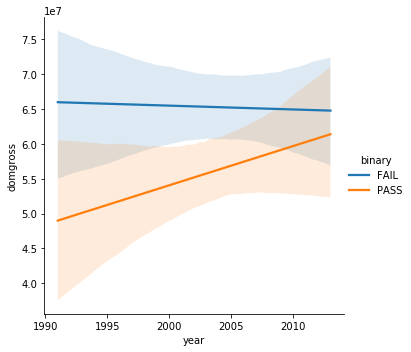

In [154]:
sns.lmplot(data = data_noout, x = 'year', y = 'domgross', markers = 'x', hue = 'binary', scatter = False)

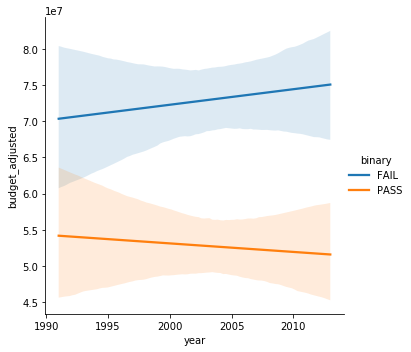

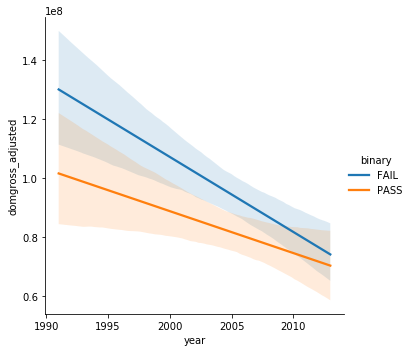

In [157]:
bug = sns.lmplot(data = data_noout, x = 'year', y = 'budget_adjusted', markers = 'x', hue = 'binary', scatter = False)
gross = sns.lmplot(data = data_noout, x = 'year', y = 'domgross_adjusted', markers = 'x', hue = 'binary', scatter = False)


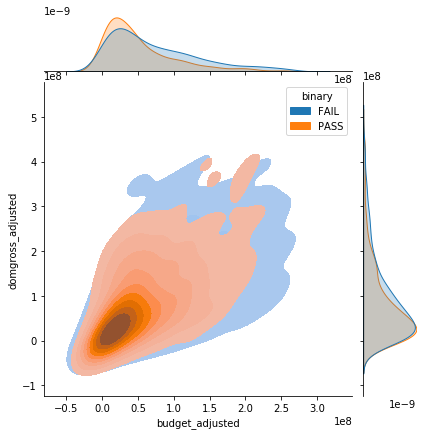

In [159]:
sns.jointplot(data = data_noout, x = 'budget_adjusted', y = 'domgross_adjusted', \
              hue = 'binary', kind = 'kde', fill = True)

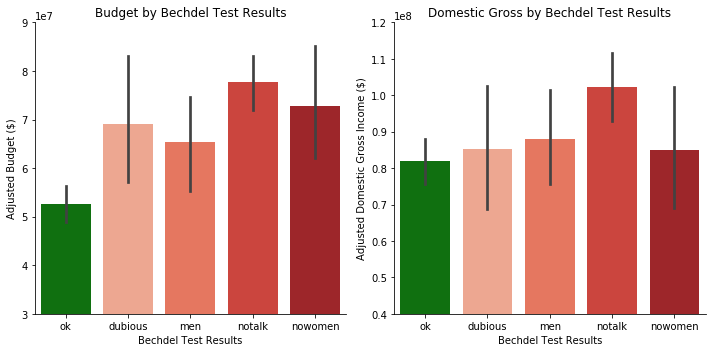

In [187]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
hue_order = ['ok',  'dubious', 'men', 'notalk', 'nowomen' ]
colors = sns.color_palette("Reds", 5)
colors [0] = 'green'
sns.barplot(data = data_noout, x = 'clean_test', y = 'domgross_adjusted', ax = ax[1], palette = colors, order = hue_order)
sns.barplot(data = data_noout, x = 'clean_test', y = 'budget_adjusted', ax = ax[0], palette = colors, order = hue_order)

ax[0].set_title('Budget by Bechdel Test Results')
ax[1].set_title('Domestic Gross by Bechdel Test Results')

ax[0].set_ylim((3e7, 9e7))
ax[1].set_ylim((4e7, 1.2e8))

ax[0].set_ylabel('Adjusted Budget ($)')
ax[1].set_ylabel('Adjusted Domestic Gross Income ($)')
ax[0].set_xlabel('Bechdel Test Results')
ax[1].set_xlabel('Bechdel Test Results')


plt.tight_layout()
sns.despine()